In [1]:
import os

In [2]:
os.getcwd()

'/Users/rutu/Desktop/INSTACART'

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv('train_model.csv')

In [5]:
test = pd.read_csv('test_model.csv')

In [6]:
train.head()

,Unnamed: 0,product_id,user_id,aisle_id,department_id,order_hour_of_day,order_dow,count,reordered,order_id,...,reoder_user_percent,avg_order_size_product,prod_count,avg_prod_order_times,from_highest_reorder_hod,bought_last_1_month,bought_last_2_month,bought_last_1_order,bought_last_3_order,sumdays
0,5433260,32429,157953,24,4,11,4,0,0,2844209,...,0.413453,17.327764,8259,2.324514,5,0,0,0,0,120
1,5525530,32916,65620,17,13,7,2,1,0,959805,...,0.039604,14.603774,106,1.049505,10,0,0,0,0,364
2,868296,5646,60430,106,12,9,6,1,0,1165507,...,0.459213,16.544177,15302,2.737388,2,0,0,0,0,362
3,7293183,43522,21886,42,1,9,4,1,0,1121667,...,0.383333,16.715400,513,2.137500,2,0,0,0,0,340
4,1442127,9076,39683,116,1,20,6,0,0,2074888,...,0.436285,14.978855,55946,2.395564,11,0,0,0,0,285


In [7]:
del train['Unnamed: 0']
del test['Unnamed: 0']

In [8]:
train_train = train.sample(frac = 0.8, random_state=200)
train_test = train.drop(train_train.index)

In [9]:
train_train_label = train_train['reordered']
train_test_lable = train_test['reordered']

In [10]:
train_train_model = train_train.drop(['product_id',
                                      'user_id',
                                      'aisle_id',
                                      'department_id',
                                      'reordered',
                                      'order_id',
                                      'eval_set'], axis=1)

train_test_model = train_test.drop(['product_id',
                                      'user_id',
                                      'aisle_id',
                                      'department_id',
                                      'reordered',
                                      'order_id',
                                      'eval_set'], axis=1)

test_model = test.drop(['product_id',
                                      'user_id',
                                      'aisle_id',
                                      'department_id',
                                      'reordered',
                                      'order_id',
                                      'eval_set'], axis=1)


In [11]:
def eval_fun(labels, preds):
    labels = labels.split(' ')
    preds = preds.split(' ')
    rr = (np.intersect1d(labels, preds))
    precision = np.float(len(rr)) / len(preds)
    recall = np.float(len(rr)) / len(labels)
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        return (precision, recall, 0.0)
    return (precision, recall, f1)

In [46]:
threshold = [0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25,0.275,0.3,0.325,0.35]
threshold

[0.0,
 0.025,
 0.05,
 0.075,
 0.1,
 0.125,
 0.15,
 0.175,
 0.2,
 0.225,
 0.25,
 0.275,
 0.3,
 0.325,
 0.35]

In [13]:
f1_score = []

In [14]:
d_train = xgb.DMatrix(train_train_model, train_train_label)

In [15]:
xgb_params = {
        "objective"         : "reg:logistic"
        ,"eval_metric"      : "logloss"
        ,"eta"              : 0.1
        ,"max_depth"        : 6
        ,"min_child_weight" :10
        ,"gamma"            :0.70
        ,"subsample"        :0.76
        ,"colsample_bytree" :0.95
        ,"alpha"            :2e-05
        ,"lambda"           :10
    }
    
watchlist= [(d_train, "train")]
    
num_round = 60
    
print('model training')
bst = xgb.train(params= xgb_params, dtrain =d_train, num_boost_round=num_round, evals= watchlist,
                    verbose_eval = 10)
    
print('predict on the test set')
preds = bst.predict(xgb.DMatrix(train_test_model))
    
train_test_copy = train_test
train_test_copy['pred'] = preds

model training
[0]	train-logloss:0.625751
[10]	train-logloss:0.335453
[20]	train-logloss:0.2684
[30]	train-logloss:0.250861
[40]	train-logloss:0.245976
[50]	train-logloss:0.244256
[59]	train-logloss:0.243239
predict on the test set


In [44]:
#0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25,0.275,0.3,0.325,0.35
d = dict()
for row in train_test_copy.itertuples():
    if row.pred >0.35:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in train_test_copy.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']

train_test_copy['true'] = train_test_lable


e = dict()
for row in train_test_copy.itertuples():
    if row.true == 1:
        try:
            e[row.order_id] += ' ' + str(row.product_id)
        except:
            e[row.order_id] = str(row.product_id)

for order in train_test_copy.order_id:
    if order not in e:
         d[order] = 'None'
        
sub_true = pd.DataFrame.from_dict(e, orient='index')

sub_true.reset_index(inplace=True)

sub_true.columns = ['order_id', 'true']
    
print('merge result')
sub_merge = pd.merge(sub_true, sub, how = 'inner', on = 'order_id')

res = list()
for entry in sub_merge.itertuples():
    res.append(eval_fun(entry[2], entry[3]))

res = pd.DataFrame(np.array(res), columns=['precision', 'recall', 'f1'])
    
print('append f1 score')
f1_score.append(np.mean(res['f1']))

merge result
append f1 score


In [45]:
f1_score

[0.31437273989466763,
 0.3553012920687362,
 0.4090012413747507,
 0.4420827288140893,
 0.45765297180955383,
 0.4613406965820962,
 0.4575863466722272,
 0.4486761021466883,
 0.43509763335189616,
 0.4199733699098601,
 0.40110331866199067,
 0.38136428158440994,
 0.36246904943408664,
 0.3419794279664389,
 0.3209017311830173]

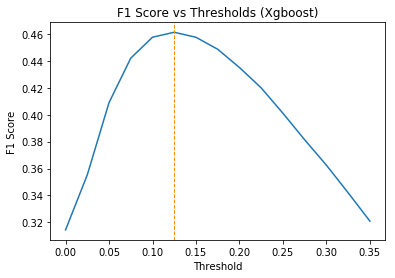

In [56]:
# Plot F1 Score vs Thresholds
plt.plot(threshold,f1_score)
plt.ylabel('F1 Score')
plt.xlabel('Threshold')
plt.axvline(x = 0.125,color='darkorange', linestyle='dashed', linewidth=1)
plt.title('F1 Score vs Thresholds (Xgboost)')
# plt.xticks(threshold, rotation = 'vertical')
plt.savefig('f1vsThresholds.png', dpi = 800, figsize = (1,1))

In [50]:
np.mean(f1_score)

0.4005935287636339

In [55]:
sub_true.head()

,order_id,true
0,1155050,48309 5869
1,2318545,2295 24852 42342 46226
2,52710,44233
3,920051,18370 2002
4,2075848,45645 22963 21137 22825 17835 43040 27966


In [58]:
train_test_lable = train_test['reordered']

In [59]:
test_lable = test['reordered']

In [60]:
test_model = test.drop(['product_id',
                                      'user_id',
                                      'aisle_id',
                                      'department_id',
                                      'reordered',
                                      'order_id',
                                      'eval_set'], axis=1)


In [61]:
prediction = bst.predict(xgb.DMatrix(test_model))

In [62]:
test_copy = test
test_copy['prediction'] = prediction

In [63]:
#with thhe threshold = 0.125
t = dict()
for row in test_copy.itertuples():
    if row.prediction >0.125:
        try:
            t[row.order_id] += ' ' + str(row.product_name)
        except:
            t[row.order_id] = str(row.product_name)

for order in test_copy.order_id:
    if order not in t:
        t[order] = 'None'

result = pd.DataFrame.from_dict(t, orient='index')

result.reset_index(inplace=True)
result.columns = ['order_id', 'products']




In [69]:
result

,order_id,products
0,2563471,1 3260 4047 4377 8859 13951 14564 18359 18790 ...
1,2383884,1 22362
2,3062074,1 13176 13575 14444 21572 45051
3,888027,1 6184 10509 13176 14444 23016 27839 31848 377...
4,2272208,1 1729 4724 12078 13176 21386 48762
5,1402459,1 6087 6729 16797 30827 31805 43352
6,2923107,1 196 17924 23194
7,2126869,1 196 19660 21100 26348 27839 31102 31422 3647...
8,2569072,1 6184 12341 13176 16797 30633 32403 43352
9,3229603,1 6184 16714 22362 27839 39408 41400 45920


In [65]:
Final_result = pd.merge(test_copy, result, how = 'inner', on = 'order_id')


In [66]:
Final_result.head()

,product_id,user_id,aisle_id,department_id,order_hour_of_day,order_dow,count,reordered,order_id,eval_set,...,prod_count,avg_prod_order_times,from_highest_reorder_hod,bought_last_1_month,bought_last_2_month,bought_last_1_order,bought_last_3_order,sumdays,prediction,products
0,1,764,61,19,10,2,1,0,2563471,test,...,1852,2.586592,7,1,1,1,1,27,0.266444,1 3260 4047 4377 8859 13951 14564 18359 18790 ...
1,3260,764,61,19,10,2,2,0,2563471,test,...,373,2.181287,7,1,1,1,1,27,0.436551,1 3260 4047 4377 8859 13951 14564 18359 18790 ...
2,4047,764,61,19,10,2,1,0,2563471,test,...,455,3.395522,7,1,1,0,1,27,0.322978,1 3260 4047 4377 8859 13951 14564 18359 18790 ...
3,4377,764,24,4,10,2,0,0,2563471,test,...,2327,2.674713,7,1,1,1,1,27,0.174869,1 3260 4047 4377 8859 13951 14564 18359 18790 ...
4,5028,764,45,19,10,2,0,0,2563471,test,...,185,1.868687,7,1,1,1,1,27,0.100207,1 3260 4047 4377 8859 13951 14564 18359 18790 ...


In [67]:
Final_result = Final_result[['user_id','order_id','products']]

In [68]:
Final_result.head()

,user_id,order_id,products
0,764,2563471,1 3260 4047 4377 8859 13951 14564 18359 18790 ...
1,764,2563471,1 3260 4047 4377 8859 13951 14564 18359 18790 ...
2,764,2563471,1 3260 4047 4377 8859 13951 14564 18359 18790 ...
3,764,2563471,1 3260 4047 4377 8859 13951 14564 18359 18790 ...
4,764,2563471,1 3260 4047 4377 8859 13951 14564 18359 18790 ...
